In [1]:
import torch
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
weather_df = pd.read_csv("../jpx-tokyo-stock-exchange-prediction/tokyo_weather_cleaned.csv",
                         parse_dates=["Date"]).set_index('Date')

In [3]:
weather_df.head()

,Average pressure,Sea level pressure,Rainfall,Max rainfall (1 hour),Max rainfall (10 mins),Ave temp,Max temp,Min temp,Ave humidity,Min humidity,Ave wind speed,Hours of sunlight,Snowfall,Max snow cover,Gust x,Gust y,Max x,Max y
Date,,,,,,,,,,,,,,,,,,
1981-01-01,1014.7,1019.2,0.0,0.0,0.0,5.0,8.9,1.3,51.0,31.0,2.5,8.7,0.0,0.0,6.744321,-2.793589,4.527010,-1.875149
1981-01-02,999.5,1003.8,2.0,2.0,1.0,4.6,7.5,1.9,81.0,42.0,2.6,3.5,0.0,0.0,-7.424621,-7.424621,-4.384062,-4.384062
1981-01-03,998.1,1002.5,0.0,0.0,0.0,5.1,9.0,2.2,40.0,19.0,4.8,8.9,0.0,0.0,-9.545942,-9.545942,-4.808326,-4.808326
1981-01-04,1004.8,1009.3,0.0,0.0,0.0,4.4,9.6,-0.6,47.0,32.0,3.8,8.6,0.0,0.0,15.613564,-6.467350,10.162675,-4.209518
1981-01-05,1006.5,1010.9,0.0,0.0,0.0,4.1,8.4,0.0,46.0,28.0,3.1,7.9,0.0,0.0,10.717003,-4.439128,6.929096,-2.870126


In [4]:
def prepare_data(df):
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col] * df['AdjustmentFactor']
    
    df.ExpectedDividend.fillna(0, inplace=True)
    df.drop(['AdjustmentFactor', 'RowId'], axis=1, inplace=True)
    df['SupervisionFlag'] = df['SupervisionFlag'].astype(int)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    
    
    df.sort_values(by=['SecuritiesCode','Date'], inplace=True)
    df['Open'].interpolate(inplace=True)
    df['High'].interpolate(inplace=True)
    df['Low'].interpolate(inplace=True)
    df['Close'].interpolate(inplace=True)
    df.loc[df['Volume'] == 0,"Volume"] = np.nan
    df['Volume'].interpolate(inplace=True)
    df['Target'].interpolate(inplace=True)
    
    return df

def create_diffs(df):
    d1 = lambda df,col: df[col].diff(periods=1)/(df[col] + 1e-8)

    for f in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df['diff' + f] = d1(df, f)
    df['pctDailyChange'] = (df['Close'] - df['Open'])/df['Close']
    df = df.dropna()
    return df

In [5]:
t = pd.read_csv("../jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv",
                parse_dates=["Date"])
t = prepare_data(t).set_index('Date')
t = create_diffs(t)

In [6]:
t = t.loc[t.index < '2021-09-28'].copy()

In [7]:
t = t.join(weather_df[['Average pressure', 'Max temp', 'Ave humidity', "Ave wind speed", 'Hours of sunlight', 'Rainfall']])
t[['Average pressure1', 'Max temp1', 'Ave humidity1',"Ave wind speed1",  'Hours of sunlight1', 'Rainfall1']] = t[['Average pressure', 'Max temp', 'Ave humidity', "Ave wind speed", 'Hours of sunlight', 'Rainfall']].shift(-1)
t[['Average pressure2', 'Max temp2', 'Ave humidity2',"Ave wind speed2",  'Hours of sunlight2', 'Rainfall2']] = t[['Average pressure', 'Max temp', 'Ave humidity', "Ave wind speed", 'Hours of sunlight', 'Rainfall']].shift(-2)
t = t.loc[t['SecuritiesCode'] == 1376].reset_index().dropna()

In [8]:
#features = [ 'diffClose', 'ExpectedDividend', 'Average pressure', 'Max temp', 'Ave humidity', 'Hours of sunlight', 'Rainfall',]
features = ['diffClose', 'diffOpen', 'diffHigh', 'diffLow', 
            'Open', 'High', 'Low', 'Close','Volume', 'ExpectedDividend', 'Month', 'Week', 'Day',
            'Average pressure', 'Max temp', 'Ave humidity', "Ave wind speed",'Hours of sunlight', 'Rainfall',
            'Average pressure1', 'Max temp1', 'Ave humidity1',"Ave wind speed1", 'Hours of sunlight1', 'Rainfall1',
            'Average pressure2', 'Max temp2', 'Ave humidity2',"Ave wind speed2", 'Hours of sunlight2', 'Rainfall2'] 
target = 'Target'
train_df = t.loc[t.Date < t.Date.unique()[-100], [*features, target]]
test_df = t.loc[t.Date >= t.Date.unique()[-100], [*features, target]]
X_train = train_df[features].to_numpy(dtype=float)
y_train = train_df[target].to_numpy(dtype=float)
X_test = test_df[features].to_numpy(dtype=float)
y_test = test_df[target].to_numpy(dtype=float)

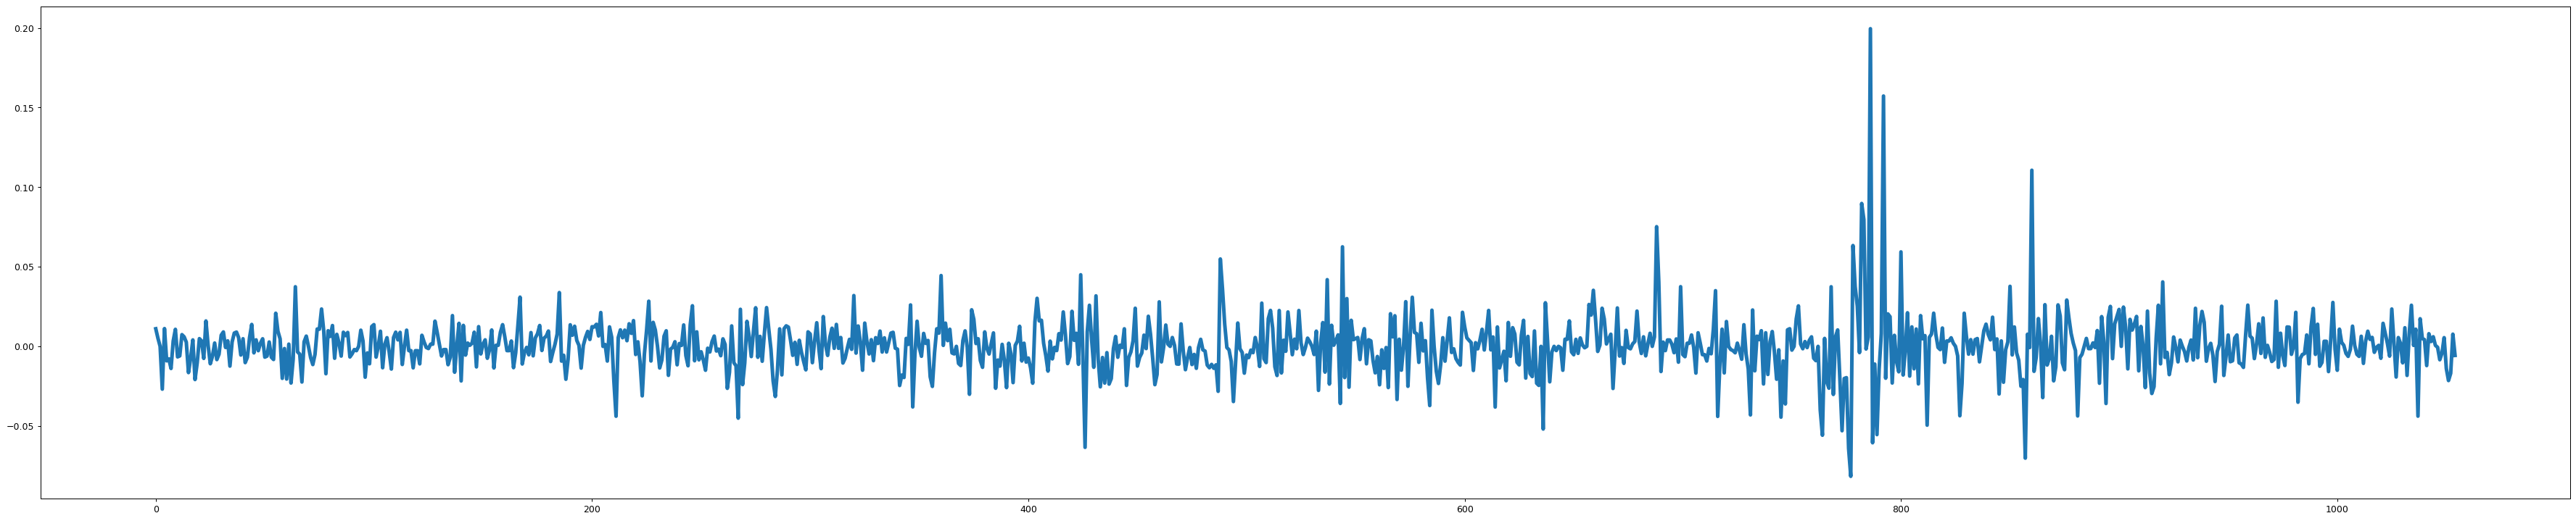

In [9]:
fig1, ax1 = plt.subplots(figsize=(50, 10), dpi=90)
ax1.plot(y_train, lw=4)

In [10]:
class Dataset(torch.utils.data.Dataset):
    # load the dataset
    def __init__(self, X, y):
        # store the inputs and outputs
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [11]:
batchSize = 16
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
val_dl = torch.utils.data.DataLoader(dataset_test, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

In [44]:
class MLP(torch.nn.Module):
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        n = 100
        self.layer1 = Linear(n_inputs, n)
        self.layer2 = Linear(n, n)
        self.layer2_1= Linear(n, n)
        self.layer3 = Linear(n, 1)
        self.activation = LeakyReLU()
        self.dropout = Dropout(p=0.15)
 
    def forward(self, X):
        X = self.layer1(X)
        X = self.activation(X) + X
        
        X = self.dropout(X) 
        X = self.layer2(X)
        X = self.activation(X) + X
        
        X = self.dropout(X) 
        X = self.layer2_1(X)
        X = self.activation(X) + X
        
        X = self.dropout(X) 
        X = self.layer3(X)
        return X

In [45]:
model = MLP(len(features)).to(device)

In [47]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, min_lr=1e-8, factor=0.5)

In [51]:
start_time = datetime.now()

for epoch in range(501):
    train_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
    
    
    if epoch % 10 == 0:
        model.eval()

        with torch.no_grad():
            eval_loss = 0
            for i, (inputs, targets) in enumerate(val_dl):
                inputs, targets = inputs.to(device), targets.to(device)
                yhat = model(inputs)
                loss = criterion(yhat, targets)
                eval_loss += loss

        scheduler.step(eval_loss)

        print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(val_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 10, train loss: tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 20, train loss: tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 30, train loss: tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 40, train loss: tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 50, train loss: tensor(0.0116, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 60, train loss: tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 70, train loss: tensor(0.0115, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.0071, device='cuda:0')
Epoch: 80, train 

In [52]:
model.eval()
with torch.no_grad():
    y_pred = []
    for i, (inputs, targets) in enumerate(test_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        yhat = model(inputs)
        y_pred.append(yhat.item())

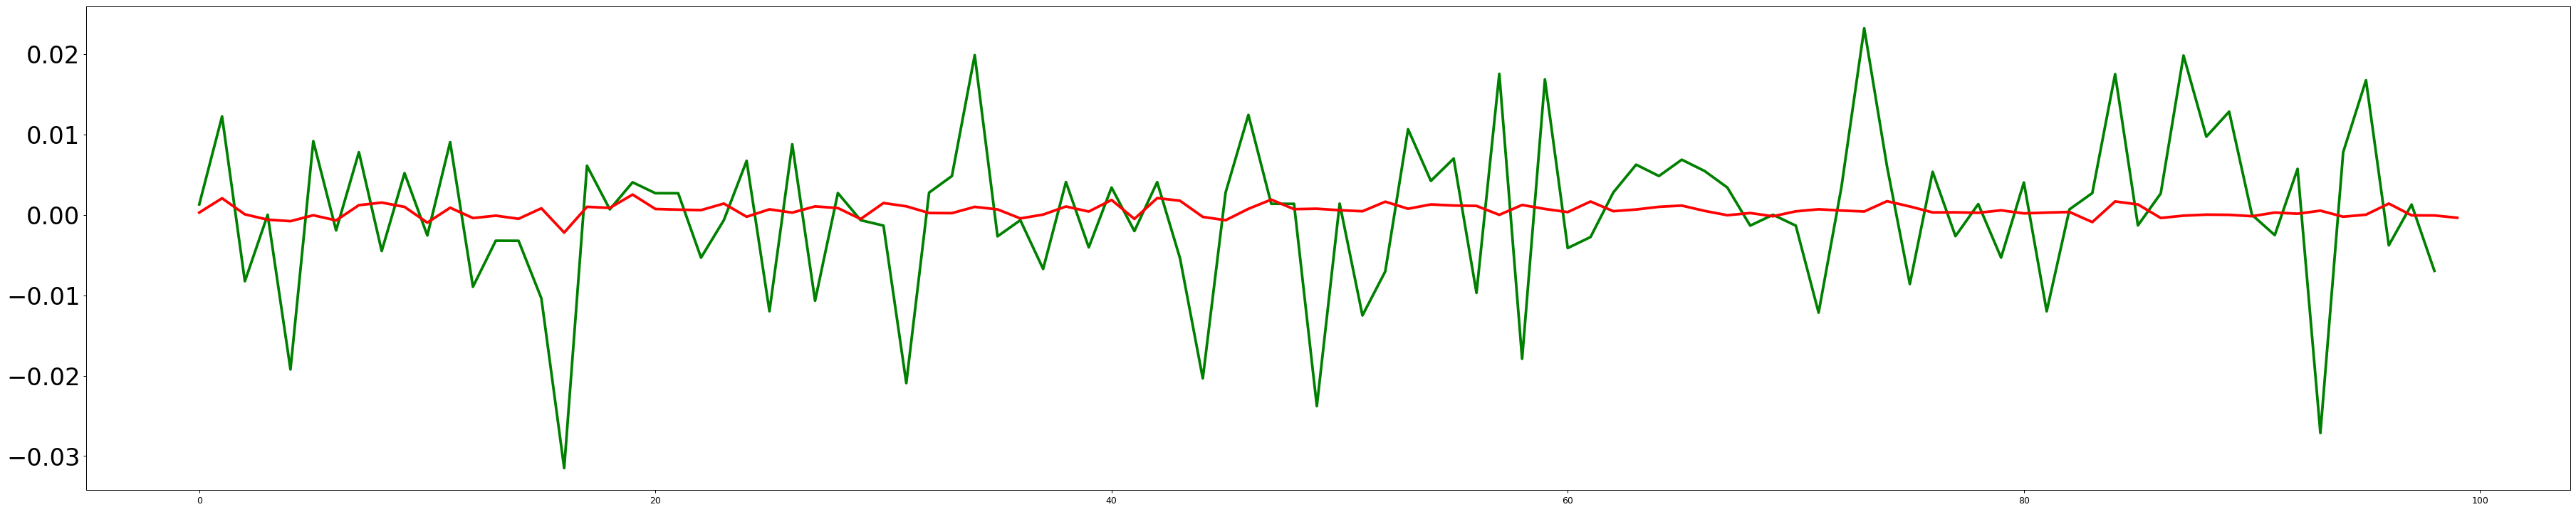

In [53]:
fig1, ax1 = plt.subplots(figsize=(50, 10), dpi=90)
ax1.tick_params(axis='y', which='both',    
                labeltop='on', labelbottom='off', labelsize=27)
ax1.plot(y_test[1:], 'g', lw=3)
ax1.plot(y_pred,'r', lw=3)

In [30]:
a = torch.Tensor(y_test[1:])
b = torch.Tensor(y_pred[:-1])  #[-0.0003]*len(y_test))
criterion(a, b)

tensor(0.0069)

In [ ]:
y_test.mean()